In [1]:
# Load the huggingface sst2 dataset
from datasets import load_dataset

dataset = load_dataset("sst2")


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [3]:
num_labels = len(set(dataset["train"]["label"]))
print(num_labels)

2


In [4]:
# Delete original test set, split the train set into train and validation, and assign original validation set to test set

dataset["test"] = dataset["validation"]

train_size = int(len(dataset["train"]) * 0.98)
train_set = dataset["train"].select(list(range(train_size)))
validation_set = dataset["train"].select(list(range(train_size, len(dataset["train"]))))
dataset["train"] = train_set
dataset["validation"] = validation_set

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 66002
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1347
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
})


In [5]:
from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# model = RobertaModel.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Print the first example of the training set
print(tokenized_dataset["train"][0])



{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [7]:
from transformers import Trainer, TrainingArguments, TrainerCallback
from datasets import load_metric
import numpy as np
import logging

# Hyperparameters
step_size = 500
lr = 5e-6
num_epochs = 3

# Eval metric for accuracy
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    result = metric.compute(predictions=predictions, references=labels)

    return result


# Custom trainer for logging training accuracy
class TrainerWithTrainingAccuracy(Trainer):
    training_accuracies = []
    # curr_step = 0

    def training_step(self, model, inputs):
        # Perform a regular training step
        loss = super().training_step(model, inputs)
        
        # Compute training accuracy after every training step
        self.log_training_accuracy(inputs)
        return loss

    def log_training_accuracy(self, inputs):
        model.eval()
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            labels = inputs["labels"]
            predictions = np.argmax(logits.cpu().numpy(), axis=-1)
            labels = labels.cpu().numpy()
            accuracy = metric.compute(predictions=predictions, references=labels)
            self.training_accuracies.append(accuracy["accuracy"])
            # self.log({"train_accuracy": accuracy["accuracy"]})
        if len(self.training_accuracies) % step_size == 0:
            self.log({"train_accuracy": sum(self.training_accuracies) / len(self.training_accuracies)})
            self.training_accuracies = []
        model.train()


training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    logging_dir='./base_logs',
    logging_steps=step_size,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=step_size,
    output_dir='./base_results',
    overwrite_output_dir=True,
    save_steps=step_size,
    save_total_limit=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=lr,
    # warmup_steps=500,
)


trainer = TrainerWithTrainingAccuracy(
    model=model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


trainer.train()




C:\Users\Shaobo Liang\AppData\Local\Temp\ipykernel_45540\1557656073.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` 

{'train_accuracy': 0.7605, 'epoch': 0.03}
{'loss': 0.5972, 'learning_rate': 4.949498010221603e-06, 'epoch': 0.03}


                                                     
  1%|          | 500/49503 [03:00<4:52:59,  2.79it/s]Checkpoint destination directory ./base_results\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.54244464635849, 'eval_accuracy': 0.888641425389755, 'eval_runtime': 26.3593, 'eval_samples_per_second': 51.102, 'eval_steps_per_second': 12.785, 'epoch': 0.03}


  2%|▏         | 1000/49503 [05:57<4:34:16,  2.95it/s] 

{'train_accuracy': 0.8935, 'epoch': 0.06}
{'loss': 0.5003, 'learning_rate': 4.898996020443206e-06, 'epoch': 0.06}


                                                      
  2%|▏         | 1000/49503 [06:23<4:34:16,  2.95it/s]Checkpoint destination directory ./base_results\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4424508810043335, 'eval_accuracy': 0.8930957683741648, 'eval_runtime': 25.3114, 'eval_samples_per_second': 53.217, 'eval_steps_per_second': 13.314, 'epoch': 0.06}


  3%|▎         | 1500/49503 [09:13<4:35:58,  2.90it/s]  

{'train_accuracy': 0.906, 'epoch': 0.09}
{'loss': 0.4716, 'learning_rate': 4.848494030664809e-06, 'epoch': 0.09}


                                                      
  3%|▎         | 1500/49503 [09:38<4:35:58,  2.90it/s]Checkpoint destination directory ./base_results\checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.456022709608078, 'eval_accuracy': 0.8990348923533779, 'eval_runtime': 25.3125, 'eval_samples_per_second': 53.215, 'eval_steps_per_second': 13.314, 'epoch': 0.09}


  4%|▍         | 2000/49503 [12:27<4:22:44,  3.01it/s]  

{'train_accuracy': 0.9135, 'epoch': 0.12}
{'loss': 0.4747, 'learning_rate': 4.797992040886411e-06, 'epoch': 0.12}


                                                      
  4%|▍         | 2000/49503 [12:53<4:22:44,  3.01it/s]Checkpoint destination directory ./base_results\checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.457669734954834, 'eval_accuracy': 0.9042316258351893, 'eval_runtime': 25.2679, 'eval_samples_per_second': 53.309, 'eval_steps_per_second': 13.337, 'epoch': 0.12}


  5%|▌         | 2500/49503 [15:42<4:23:44,  2.97it/s]  

{'train_accuracy': 0.9205, 'epoch': 0.15}
{'loss': 0.4328, 'learning_rate': 4.747490051108014e-06, 'epoch': 0.15}


                                                      
  5%|▌         | 2500/49503 [16:08<4:23:44,  2.97it/s]Checkpoint destination directory ./base_results\checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5025954246520996, 'eval_accuracy': 0.9042316258351893, 'eval_runtime': 25.3342, 'eval_samples_per_second': 53.169, 'eval_steps_per_second': 13.302, 'epoch': 0.15}


  6%|▌         | 3000/49503 [18:57<4:23:53,  2.94it/s]  

{'train_accuracy': 0.907, 'epoch': 0.18}
{'loss': 0.494, 'learning_rate': 4.696988061329617e-06, 'epoch': 0.18}


                                                      
  6%|▌         | 3000/49503 [19:23<4:23:53,  2.94it/s]Checkpoint destination directory ./base_results\checkpoint-3000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4307214319705963, 'eval_accuracy': 0.9072011878247959, 'eval_runtime': 25.4601, 'eval_samples_per_second': 52.906, 'eval_steps_per_second': 13.236, 'epoch': 0.18}


  7%|▋         | 3500/49503 [22:13<4:24:29,  2.90it/s]  

{'train_accuracy': 0.9165, 'epoch': 0.21}
{'loss': 0.4429, 'learning_rate': 4.64648607155122e-06, 'epoch': 0.21}


                                                      
  7%|▋         | 3500/49503 [22:38<4:24:29,  2.90it/s]Checkpoint destination directory ./base_results\checkpoint-3500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.48612135648727417, 'eval_accuracy': 0.9034892353377877, 'eval_runtime': 25.1145, 'eval_samples_per_second': 53.634, 'eval_steps_per_second': 13.419, 'epoch': 0.21}


  8%|▊         | 4000/49503 [25:27<4:14:43,  2.98it/s]  

{'train_accuracy': 0.908, 'epoch': 0.24}
{'loss': 0.4407, 'learning_rate': 4.5959840817728226e-06, 'epoch': 0.24}


                                                      
  8%|▊         | 4000/49503 [25:52<4:14:43,  2.98it/s]Checkpoint destination directory ./base_results\checkpoint-4000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.36658617854118347, 'eval_accuracy': 0.9153674832962138, 'eval_runtime': 25.4467, 'eval_samples_per_second': 52.934, 'eval_steps_per_second': 13.243, 'epoch': 0.24}


  9%|▉         | 4500/49503 [28:43<4:11:26,  2.98it/s]  

{'train_accuracy': 0.918, 'epoch': 0.27}
{'loss': 0.4716, 'learning_rate': 4.545482091994425e-06, 'epoch': 0.27}


                                                      
  9%|▉         | 4500/49503 [29:08<4:11:26,  2.98it/s]Checkpoint destination directory ./base_results\checkpoint-4500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.370566725730896, 'eval_accuracy': 0.9183370452858204, 'eval_runtime': 25.276, 'eval_samples_per_second': 53.292, 'eval_steps_per_second': 13.333, 'epoch': 0.27}


 10%|█         | 5000/49503 [31:58<4:11:20,  2.95it/s]  

{'train_accuracy': 0.923, 'epoch': 0.3}
{'loss': 0.4495, 'learning_rate': 4.4949801022160275e-06, 'epoch': 0.3}


                                                      
 10%|█         | 5000/49503 [32:23<4:11:20,  2.95it/s]Checkpoint destination directory ./base_results\checkpoint-5000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.42527061700820923, 'eval_accuracy': 0.9072011878247959, 'eval_runtime': 25.5482, 'eval_samples_per_second': 52.724, 'eval_steps_per_second': 13.191, 'epoch': 0.3}


 11%|█         | 5500/49503 [35:13<4:10:36,  2.93it/s]  

{'train_accuracy': 0.922, 'epoch': 0.33}
{'loss': 0.4138, 'learning_rate': 4.44447811243763e-06, 'epoch': 0.33}


                                                      
 11%|█         | 5500/49503 [35:38<4:10:36,  2.93it/s]Checkpoint destination directory ./base_results\checkpoint-5500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4108375906944275, 'eval_accuracy': 0.9161098737936154, 'eval_runtime': 25.3221, 'eval_samples_per_second': 53.195, 'eval_steps_per_second': 13.309, 'epoch': 0.33}


 12%|█▏        | 6000/49503 [38:28<4:02:13,  2.99it/s]  

{'train_accuracy': 0.9305, 'epoch': 0.36}
{'loss': 0.3737, 'learning_rate': 4.393976122659233e-06, 'epoch': 0.36}


                                                      
 12%|█▏        | 6000/49503 [38:53<4:02:13,  2.99it/s]Checkpoint destination directory ./base_results\checkpoint-6000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5163946747779846, 'eval_accuracy': 0.9072011878247959, 'eval_runtime': 25.3503, 'eval_samples_per_second': 53.136, 'eval_steps_per_second': 13.294, 'epoch': 0.36}


 13%|█▎        | 6500/49503 [41:43<4:07:14,  2.90it/s] 

{'train_accuracy': 0.922, 'epoch': 0.39}
{'loss': 0.4351, 'learning_rate': 4.343474132880836e-06, 'epoch': 0.39}


                                                      
 13%|█▎        | 6500/49503 [42:08<4:07:14,  2.90it/s]Checkpoint destination directory ./base_results\checkpoint-6500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.410427451133728, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 25.8691, 'eval_samples_per_second': 52.07, 'eval_steps_per_second': 13.027, 'epoch': 0.39}


 14%|█▍        | 7000/49503 [45:06<4:05:22,  2.89it/s]  

{'train_accuracy': 0.9245, 'epoch': 0.42}
{'loss': 0.4298, 'learning_rate': 4.292972143102438e-06, 'epoch': 0.42}


                                                      
 14%|█▍        | 7000/49503 [45:32<4:05:22,  2.89it/s]Checkpoint destination directory ./base_results\checkpoint-7000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.398214191198349, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 25.5494, 'eval_samples_per_second': 52.721, 'eval_steps_per_second': 13.19, 'epoch': 0.42}


 15%|█▌        | 7500/49503 [48:26<3:55:55,  2.97it/s] 

{'train_accuracy': 0.934, 'epoch': 0.45}
{'loss': 0.4123, 'learning_rate': 4.242470153324042e-06, 'epoch': 0.45}


                                                      
 15%|█▌        | 7500/49503 [48:52<3:55:55,  2.97it/s]Checkpoint destination directory ./base_results\checkpoint-7500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3890305757522583, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 25.7565, 'eval_samples_per_second': 52.297, 'eval_steps_per_second': 13.084, 'epoch': 0.45}


 16%|█▌        | 8000/49503 [51:41<3:53:59,  2.96it/s] 

{'train_accuracy': 0.929, 'epoch': 0.48}
{'loss': 0.3669, 'learning_rate': 4.191968163545644e-06, 'epoch': 0.48}


                                                      
 16%|█▌        | 8000/49503 [52:07<3:53:59,  2.96it/s]Checkpoint destination directory ./base_results\checkpoint-8000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4171425402164459, 'eval_accuracy': 0.9205642167780252, 'eval_runtime': 25.2862, 'eval_samples_per_second': 53.27, 'eval_steps_per_second': 13.327, 'epoch': 0.48}


 17%|█▋        | 8500/49503 [54:57<3:53:26,  2.93it/s] 

{'train_accuracy': 0.937, 'epoch': 0.52}
{'loss': 0.3746, 'learning_rate': 4.141466173767247e-06, 'epoch': 0.52}


                                                      
 17%|█▋        | 8500/49503 [55:22<3:53:26,  2.93it/s]Checkpoint destination directory ./base_results\checkpoint-8500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3826692998409271, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 25.0574, 'eval_samples_per_second': 53.757, 'eval_steps_per_second': 13.449, 'epoch': 0.52}


 18%|█▊        | 9000/49503 [58:11<3:40:11,  3.07it/s] 

{'train_accuracy': 0.9285, 'epoch': 0.55}
{'loss': 0.4084, 'learning_rate': 4.09096418398885e-06, 'epoch': 0.55}


                                                      
 18%|█▊        | 9000/49503 [58:36<3:40:11,  3.07it/s]Checkpoint destination directory ./base_results\checkpoint-9000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3991307318210602, 'eval_accuracy': 0.9213066072754269, 'eval_runtime': 25.2725, 'eval_samples_per_second': 53.299, 'eval_steps_per_second': 13.335, 'epoch': 0.55}


 19%|█▉        | 9500/49503 [1:01:25<3:50:52,  2.89it/s]

{'train_accuracy': 0.93, 'epoch': 0.58}
{'loss': 0.4048, 'learning_rate': 4.0404621942104525e-06, 'epoch': 0.58}


                                                        
 19%|█▉        | 9500/49503 [1:01:51<3:50:52,  2.89it/s]Checkpoint destination directory ./base_results\checkpoint-9500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.41234299540519714, 'eval_accuracy': 0.9220489977728286, 'eval_runtime': 25.8012, 'eval_samples_per_second': 52.207, 'eval_steps_per_second': 13.061, 'epoch': 0.58}


 20%|██        | 10000/49503 [1:04:42<3:43:00,  2.95it/s]

{'train_accuracy': 0.924, 'epoch': 0.61}
{'loss': 0.407, 'learning_rate': 3.989960204432055e-06, 'epoch': 0.61}


                                                         
 20%|██        | 10000/49503 [1:05:07<3:43:00,  2.95it/s]Checkpoint destination directory ./base_results\checkpoint-10000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3684168756008148, 'eval_accuracy': 0.9190794357832219, 'eval_runtime': 25.1978, 'eval_samples_per_second': 53.457, 'eval_steps_per_second': 13.374, 'epoch': 0.61}


 21%|██        | 10500/49503 [1:07:56<3:47:36,  2.86it/s] 

{'train_accuracy': 0.9335, 'epoch': 0.64}
{'loss': 0.3749, 'learning_rate': 3.939458214653657e-06, 'epoch': 0.64}


                                                         
 21%|██        | 10500/49503 [1:08:22<3:47:36,  2.86it/s]Checkpoint destination directory ./base_results\checkpoint-10500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3991338014602661, 'eval_accuracy': 0.9205642167780252, 'eval_runtime': 25.1322, 'eval_samples_per_second': 53.597, 'eval_steps_per_second': 13.409, 'epoch': 0.64}


 22%|██▏       | 11000/49503 [1:11:11<3:29:31,  3.06it/s] 

{'train_accuracy': 0.9375, 'epoch': 0.67}
{'loss': 0.3584, 'learning_rate': 3.88895622487526e-06, 'epoch': 0.67}


                                                         
 22%|██▏       | 11000/49503 [1:11:36<3:29:31,  3.06it/s]Checkpoint destination directory ./base_results\checkpoint-11000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.441349059343338, 'eval_accuracy': 0.9205642167780252, 'eval_runtime': 25.3229, 'eval_samples_per_second': 53.193, 'eval_steps_per_second': 13.308, 'epoch': 0.67}


 23%|██▎       | 11500/49503 [1:14:26<3:33:26,  2.97it/s] 

{'train_accuracy': 0.9295, 'epoch': 0.7}
{'loss': 0.4086, 'learning_rate': 3.838454235096863e-06, 'epoch': 0.7}


                                                         
 23%|██▎       | 11500/49503 [1:14:51<3:33:26,  2.97it/s]Checkpoint destination directory ./base_results\checkpoint-11500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3575245141983032, 'eval_accuracy': 0.9272457312546399, 'eval_runtime': 25.2681, 'eval_samples_per_second': 53.308, 'eval_steps_per_second': 13.337, 'epoch': 0.7}


 24%|██▍       | 12000/49503 [1:17:41<3:34:30,  2.91it/s] 

{'train_accuracy': 0.938, 'epoch': 0.73}
{'loss': 0.3712, 'learning_rate': 3.787952245318466e-06, 'epoch': 0.73}


                                                         
 24%|██▍       | 12000/49503 [1:18:07<3:34:30,  2.91it/s]Checkpoint destination directory ./base_results\checkpoint-12000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3952305018901825, 'eval_accuracy': 0.9309576837416481, 'eval_runtime': 25.5249, 'eval_samples_per_second': 52.772, 'eval_steps_per_second': 13.203, 'epoch': 0.73}


 25%|██▌       | 12500/49503 [1:20:57<3:32:18,  2.90it/s] 

{'train_accuracy': 0.9375, 'epoch': 0.76}
{'loss': 0.3696, 'learning_rate': 3.737450255540069e-06, 'epoch': 0.76}


                                                         
 25%|██▌       | 12500/49503 [1:21:23<3:32:18,  2.90it/s]Checkpoint destination directory ./base_results\checkpoint-12500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.40746426582336426, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 25.6082, 'eval_samples_per_second': 52.6, 'eval_steps_per_second': 13.16, 'epoch': 0.76}


 26%|██▋       | 13000/49503 [1:23:34<1:58:44,  5.12it/s] 

{'train_accuracy': 0.9485, 'epoch': 0.79}
{'loss': 0.3289, 'learning_rate': 3.6869482657616714e-06, 'epoch': 0.79}


                                                         
 26%|██▋       | 13000/49503 [1:23:50<1:58:44,  5.12it/s]

{'eval_loss': 0.3614369332790375, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 15.9753, 'eval_samples_per_second': 84.318, 'eval_steps_per_second': 21.095, 'epoch': 0.79}


 27%|██▋       | 13500/49503 [1:25:37<1:59:50,  5.01it/s] 

{'train_accuracy': 0.934, 'epoch': 0.82}
{'loss': 0.3611, 'learning_rate': 3.6364462759832742e-06, 'epoch': 0.82}


                                                         
 27%|██▋       | 13500/49503 [1:25:53<1:59:50,  5.01it/s]Checkpoint destination directory ./base_results\checkpoint-13500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.39570197463035583, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 16.0167, 'eval_samples_per_second': 84.1, 'eval_steps_per_second': 21.041, 'epoch': 0.82}


 28%|██▊       | 14000/49503 [1:27:39<1:54:33,  5.17it/s] 

{'train_accuracy': 0.931, 'epoch': 0.85}
{'loss': 0.3839, 'learning_rate': 3.5859442862048767e-06, 'epoch': 0.85}


                                                         
 28%|██▊       | 14000/49503 [1:27:55<1:54:33,  5.17it/s]Checkpoint destination directory ./base_results\checkpoint-14000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.36495932936668396, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 15.9907, 'eval_samples_per_second': 84.236, 'eval_steps_per_second': 21.075, 'epoch': 0.85}


 29%|██▉       | 14500/49503 [1:29:41<2:09:47,  4.49it/s] 

{'train_accuracy': 0.9355, 'epoch': 0.88}
{'loss': 0.3603, 'learning_rate': 3.5354422964264796e-06, 'epoch': 0.88}


                                                         
 29%|██▉       | 14500/49503 [1:29:57<2:09:47,  4.49it/s]Checkpoint destination directory ./base_results\checkpoint-14500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3579840064048767, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 16.0004, 'eval_samples_per_second': 84.185, 'eval_steps_per_second': 21.062, 'epoch': 0.88}


 30%|███       | 15000/49503 [1:31:44<2:00:51,  4.76it/s] 

{'train_accuracy': 0.9365, 'epoch': 0.91}
{'loss': 0.3784, 'learning_rate': 3.4849403066480825e-06, 'epoch': 0.91}


                                                         
 30%|███       | 15000/49503 [1:32:00<2:00:51,  4.76it/s]Checkpoint destination directory ./base_results\checkpoint-15000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.34032177925109863, 'eval_accuracy': 0.9346696362286563, 'eval_runtime': 16.1581, 'eval_samples_per_second': 83.364, 'eval_steps_per_second': 20.856, 'epoch': 0.91}


 31%|███▏      | 15500/49503 [1:33:45<2:07:58,  4.43it/s] 

{'train_accuracy': 0.937, 'epoch': 0.94}
{'loss': 0.3626, 'learning_rate': 3.434438316869685e-06, 'epoch': 0.94}


                                                         
 31%|███▏      | 15500/49503 [1:34:03<2:07:58,  4.43it/s]Checkpoint destination directory ./base_results\checkpoint-15500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.34703487157821655, 'eval_accuracy': 0.9324424647364514, 'eval_runtime': 17.5182, 'eval_samples_per_second': 76.891, 'eval_steps_per_second': 19.237, 'epoch': 0.94}


 32%|███▏      | 16000/49503 [1:35:49<1:45:26,  5.30it/s] 

{'train_accuracy': 0.9415, 'epoch': 0.97}
{'loss': 0.341, 'learning_rate': 3.3839363270912878e-06, 'epoch': 0.97}


                                                         
 32%|███▏      | 16000/49503 [1:36:05<1:45:26,  5.30it/s]Checkpoint destination directory ./base_results\checkpoint-16000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3383961617946625, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 16.0147, 'eval_samples_per_second': 84.11, 'eval_steps_per_second': 21.043, 'epoch': 0.97}


 33%|███▎      | 16500/49503 [1:37:59<1:55:32,  4.76it/s] 

{'train_accuracy': 0.941, 'epoch': 1.0}
{'loss': 0.3154, 'learning_rate': 3.3334343373128902e-06, 'epoch': 1.0}


                                                         
 33%|███▎      | 16500/49503 [1:38:15<1:55:32,  4.76it/s]Checkpoint destination directory ./base_results\checkpoint-16500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.34536290168762207, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 16.3823, 'eval_samples_per_second': 82.223, 'eval_steps_per_second': 20.571, 'epoch': 1.0}


 34%|███▍      | 17000/49503 [1:40:04<1:46:16,  5.10it/s] 

{'train_accuracy': 0.96, 'epoch': 1.03}
{'loss': 0.2781, 'learning_rate': 3.282932347534493e-06, 'epoch': 1.03}


                                                         
 34%|███▍      | 17000/49503 [1:40:20<1:46:16,  5.10it/s]Checkpoint destination directory ./base_results\checkpoint-17000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3740359842777252, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 16.3605, 'eval_samples_per_second': 82.333, 'eval_steps_per_second': 20.598, 'epoch': 1.03}


 35%|███▌      | 17500/49503 [1:42:09<1:42:36,  5.20it/s] 

{'train_accuracy': 0.963, 'epoch': 1.06}
{'loss': 0.2212, 'learning_rate': 3.2324303577560956e-06, 'epoch': 1.06}


                                                         
 35%|███▌      | 17500/49503 [1:42:25<1:42:36,  5.20it/s]Checkpoint destination directory ./base_results\checkpoint-17500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.38575151562690735, 'eval_accuracy': 0.9354120267260579, 'eval_runtime': 16.3327, 'eval_samples_per_second': 82.473, 'eval_steps_per_second': 20.634, 'epoch': 1.06}


 36%|███▋      | 18000/49503 [1:44:14<1:46:46,  4.92it/s] 

{'train_accuracy': 0.9595, 'epoch': 1.09}
{'loss': 0.2824, 'learning_rate': 3.1819283679776984e-06, 'epoch': 1.09}


                                                         
 36%|███▋      | 18000/49503 [1:44:31<1:46:46,  4.92it/s]Checkpoint destination directory ./base_results\checkpoint-18000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3328120708465576, 'eval_accuracy': 0.9376391982182628, 'eval_runtime': 16.4364, 'eval_samples_per_second': 81.952, 'eval_steps_per_second': 20.503, 'epoch': 1.09}


 37%|███▋      | 18500/49503 [1:46:20<1:56:05,  4.45it/s] 

{'train_accuracy': 0.9645, 'epoch': 1.12}
{'loss': 0.2447, 'learning_rate': 3.1314263781993013e-06, 'epoch': 1.12}


                                                         
 37%|███▋      | 18500/49503 [1:46:37<1:56:05,  4.45it/s]Checkpoint destination directory ./base_results\checkpoint-18500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.41894033551216125, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 16.9564, 'eval_samples_per_second': 79.439, 'eval_steps_per_second': 19.875, 'epoch': 1.12}


 38%|███▊      | 19000/49503 [1:48:26<1:54:01,  4.46it/s] 

{'train_accuracy': 0.966, 'epoch': 1.15}
{'loss': 0.2408, 'learning_rate': 3.0809243884209038e-06, 'epoch': 1.15}


                                                         
 38%|███▊      | 19000/49503 [1:48:43<1:54:01,  4.46it/s]Checkpoint destination directory ./base_results\checkpoint-19000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4113834798336029, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 16.9367, 'eval_samples_per_second': 79.531, 'eval_steps_per_second': 19.898, 'epoch': 1.15}


 39%|███▉      | 19500/49503 [1:50:31<1:53:30,  4.41it/s] 

{'train_accuracy': 0.957, 'epoch': 1.18}
{'loss': 0.3072, 'learning_rate': 3.030422398642507e-06, 'epoch': 1.18}


                                                         
 39%|███▉      | 19500/49503 [1:50:48<1:53:30,  4.41it/s]Checkpoint destination directory ./base_results\checkpoint-19500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.41534891724586487, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 16.2086, 'eval_samples_per_second': 83.104, 'eval_steps_per_second': 20.791, 'epoch': 1.18}


 40%|████      | 20000/49503 [1:52:37<1:41:46,  4.83it/s] 

{'train_accuracy': 0.9615, 'epoch': 1.21}
{'loss': 0.249, 'learning_rate': 2.979920408864109e-06, 'epoch': 1.21}


                                                         
 40%|████      | 20000/49503 [1:52:53<1:41:46,  4.83it/s]Checkpoint destination directory ./base_results\checkpoint-20000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3858800232410431, 'eval_accuracy': 0.9346696362286563, 'eval_runtime': 16.3539, 'eval_samples_per_second': 82.365, 'eval_steps_per_second': 20.607, 'epoch': 1.21}


 41%|████▏     | 20500/49503 [1:54:42<1:48:57,  4.44it/s] 

{'train_accuracy': 0.9605, 'epoch': 1.24}
{'loss': 0.2744, 'learning_rate': 2.9294184190857124e-06, 'epoch': 1.24}


                                                         
 41%|████▏     | 20500/49503 [1:54:59<1:48:57,  4.44it/s]Checkpoint destination directory ./base_results\checkpoint-20500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.37913909554481506, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 16.335, 'eval_samples_per_second': 82.461, 'eval_steps_per_second': 20.631, 'epoch': 1.24}


 42%|████▏     | 21000/49503 [1:56:48<1:44:33,  4.54it/s] 

{'train_accuracy': 0.9555, 'epoch': 1.27}
{'loss': 0.293, 'learning_rate': 2.8789164293073153e-06, 'epoch': 1.27}


                                                         
 42%|████▏     | 21000/49503 [1:57:04<1:44:33,  4.54it/s]Checkpoint destination directory ./base_results\checkpoint-21000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.366295725107193, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 16.2851, 'eval_samples_per_second': 82.714, 'eval_steps_per_second': 20.694, 'epoch': 1.27}


 43%|████▎     | 21500/49503 [1:58:55<1:41:26,  4.60it/s] 

{'train_accuracy': 0.96, 'epoch': 1.3}
{'loss': 0.268, 'learning_rate': 2.8284144395289177e-06, 'epoch': 1.3}


                                                         
 43%|████▎     | 21500/49503 [1:59:12<1:41:26,  4.60it/s]Checkpoint destination directory ./base_results\checkpoint-21500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.41962218284606934, 'eval_accuracy': 0.9302152932442465, 'eval_runtime': 17.1257, 'eval_samples_per_second': 78.654, 'eval_steps_per_second': 19.678, 'epoch': 1.3}


 44%|████▍     | 22000/49503 [2:00:58<1:43:55,  4.41it/s] 

{'train_accuracy': 0.962, 'epoch': 1.33}
{'loss': 0.2775, 'learning_rate': 2.7779124497505206e-06, 'epoch': 1.33}


                                                         
 44%|████▍     | 22000/49503 [2:01:14<1:43:55,  4.41it/s]Checkpoint destination directory ./base_results\checkpoint-22000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4148487448692322, 'eval_accuracy': 0.9279881217520416, 'eval_runtime': 16.4429, 'eval_samples_per_second': 81.92, 'eval_steps_per_second': 20.495, 'epoch': 1.33}


 45%|████▌     | 22500/49503 [2:03:01<1:28:08,  5.11it/s] 

{'train_accuracy': 0.958, 'epoch': 1.36}
{'loss': 0.2631, 'learning_rate': 2.727410459972123e-06, 'epoch': 1.36}


                                                         
 45%|████▌     | 22500/49503 [2:03:17<1:28:08,  5.11it/s]Checkpoint destination directory ./base_results\checkpoint-22500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.37454721331596375, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 16.1508, 'eval_samples_per_second': 83.401, 'eval_steps_per_second': 20.866, 'epoch': 1.36}


 46%|████▋     | 23000/49503 [2:05:05<1:35:18,  4.63it/s] 

{'train_accuracy': 0.9615, 'epoch': 1.39}
{'loss': 0.2361, 'learning_rate': 2.676908470193726e-06, 'epoch': 1.39}


                                                         
 46%|████▋     | 23000/49503 [2:05:21<1:35:18,  4.63it/s]Checkpoint destination directory ./base_results\checkpoint-23000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.39788731932640076, 'eval_accuracy': 0.9339272457312546, 'eval_runtime': 16.0961, 'eval_samples_per_second': 83.685, 'eval_steps_per_second': 20.937, 'epoch': 1.39}


 47%|████▋     | 23500/49503 [2:07:09<1:41:06,  4.29it/s] 

{'train_accuracy': 0.9575, 'epoch': 1.42}
{'loss': 0.3098, 'learning_rate': 2.6264064804153284e-06, 'epoch': 1.42}


                                                         
 47%|████▋     | 23500/49503 [2:07:25<1:41:06,  4.29it/s]Checkpoint destination directory ./base_results\checkpoint-23500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3604927062988281, 'eval_accuracy': 0.933184855233853, 'eval_runtime': 16.124, 'eval_samples_per_second': 83.54, 'eval_steps_per_second': 20.901, 'epoch': 1.42}


 48%|████▊     | 24000/49503 [2:09:11<1:31:00,  4.67it/s] 

{'train_accuracy': 0.956, 'epoch': 1.45}
{'loss': 0.2806, 'learning_rate': 2.5759044906369313e-06, 'epoch': 1.45}


                                                         
 48%|████▊     | 24000/49503 [2:09:27<1:31:00,  4.67it/s]Checkpoint destination directory ./base_results\checkpoint-24000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3861020505428314, 'eval_accuracy': 0.9346696362286563, 'eval_runtime': 16.1192, 'eval_samples_per_second': 83.565, 'eval_steps_per_second': 20.907, 'epoch': 1.45}


 49%|████▉     | 24500/49503 [2:11:15<1:28:55,  4.69it/s] 

{'train_accuracy': 0.9645, 'epoch': 1.48}
{'loss': 0.2735, 'learning_rate': 2.525402500858534e-06, 'epoch': 1.48}


                                                         
 49%|████▉     | 24500/49503 [2:11:31<1:28:55,  4.69it/s]Checkpoint destination directory ./base_results\checkpoint-24500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.37356722354888916, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 16.4754, 'eval_samples_per_second': 81.758, 'eval_steps_per_second': 20.455, 'epoch': 1.48}


 51%|█████     | 25000/49503 [2:13:19<1:31:12,  4.48it/s] 

{'train_accuracy': 0.9605, 'epoch': 1.51}
{'loss': 0.2439, 'learning_rate': 2.4749005110801366e-06, 'epoch': 1.52}


                                                         
 51%|█████     | 25000/49503 [2:13:35<1:31:12,  4.48it/s]Checkpoint destination directory ./base_results\checkpoint-25000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3343009650707245, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 16.7563, 'eval_samples_per_second': 80.388, 'eval_steps_per_second': 20.112, 'epoch': 1.52}


 52%|█████▏    | 25500/49503 [2:15:22<1:17:52,  5.14it/s] 

{'train_accuracy': 0.964, 'epoch': 1.55}
{'loss': 0.2436, 'learning_rate': 2.4243985213017395e-06, 'epoch': 1.55}


                                                         
 52%|█████▏    | 25500/49503 [2:15:38<1:17:52,  5.14it/s]Checkpoint destination directory ./base_results\checkpoint-25500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.34623467922210693, 'eval_accuracy': 0.9383815887156645, 'eval_runtime': 16.1447, 'eval_samples_per_second': 83.433, 'eval_steps_per_second': 20.874, 'epoch': 1.55}


 53%|█████▎    | 26000/49503 [2:17:33<1:23:28,  4.69it/s] 

{'train_accuracy': 0.9575, 'epoch': 1.58}
{'loss': 0.272, 'learning_rate': 2.3738965315233423e-06, 'epoch': 1.58}


                                                         
 53%|█████▎    | 26000/49503 [2:17:50<1:23:28,  4.69it/s]Checkpoint destination directory ./base_results\checkpoint-26000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3258608281612396, 'eval_accuracy': 0.9406087602078693, 'eval_runtime': 16.715, 'eval_samples_per_second': 80.586, 'eval_steps_per_second': 20.162, 'epoch': 1.58}


 54%|█████▎    | 26500/49503 [2:19:41<1:26:13,  4.45it/s] 

{'train_accuracy': 0.9605, 'epoch': 1.61}
{'loss': 0.2682, 'learning_rate': 2.3233945417449448e-06, 'epoch': 1.61}


                                                         
 54%|█████▎    | 26500/49503 [2:19:57<1:26:13,  4.45it/s]Checkpoint destination directory ./base_results\checkpoint-26500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.33600008487701416, 'eval_accuracy': 0.941351150705271, 'eval_runtime': 16.6559, 'eval_samples_per_second': 80.872, 'eval_steps_per_second': 20.233, 'epoch': 1.61}


 55%|█████▍    | 27000/49503 [2:21:49<1:22:10,  4.56it/s] 

{'train_accuracy': 0.9565, 'epoch': 1.64}
{'loss': 0.2777, 'learning_rate': 2.2728925519665477e-06, 'epoch': 1.64}


                                                         
 55%|█████▍    | 27000/49503 [2:22:05<1:22:10,  4.56it/s]Checkpoint destination directory ./base_results\checkpoint-27000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3453977704048157, 'eval_accuracy': 0.9443207126948775, 'eval_runtime': 16.6954, 'eval_samples_per_second': 80.681, 'eval_steps_per_second': 20.185, 'epoch': 1.64}


 56%|█████▌    | 27500/49503 [2:23:52<1:12:37,  5.05it/s] 

{'train_accuracy': 0.962, 'epoch': 1.67}
{'loss': 0.2498, 'learning_rate': 2.22239056218815e-06, 'epoch': 1.67}


                                                         
 56%|█████▌    | 27500/49503 [2:24:08<1:12:37,  5.05it/s]Checkpoint destination directory ./base_results\checkpoint-27500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.35382696986198425, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 16.1156, 'eval_samples_per_second': 83.584, 'eval_steps_per_second': 20.911, 'epoch': 1.67}


 57%|█████▋    | 28000/49503 [2:25:56<1:19:35,  4.50it/s] 

{'train_accuracy': 0.956, 'epoch': 1.7}
{'loss': 0.2877, 'learning_rate': 2.1718885724097534e-06, 'epoch': 1.7}


                                                         
 57%|█████▋    | 28000/49503 [2:26:26<1:19:35,  4.50it/s]Checkpoint destination directory ./base_results\checkpoint-28000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.34546178579330444, 'eval_accuracy': 0.9368968077208611, 'eval_runtime': 29.7136, 'eval_samples_per_second': 45.333, 'eval_steps_per_second': 11.342, 'epoch': 1.7}


 58%|█████▊    | 28500/49503 [2:28:11<1:09:23,  5.04it/s] 

{'train_accuracy': 0.9585, 'epoch': 1.73}
{'loss': 0.2671, 'learning_rate': 2.121386582631356e-06, 'epoch': 1.73}


                                                         
 58%|█████▊    | 28500/49503 [2:28:27<1:09:23,  5.04it/s]Checkpoint destination directory ./base_results\checkpoint-28500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3206811249256134, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 15.7244, 'eval_samples_per_second': 85.663, 'eval_steps_per_second': 21.432, 'epoch': 1.73}


 59%|█████▊    | 29000/49503 [2:30:11<1:11:16,  4.79it/s] 

{'train_accuracy': 0.962, 'epoch': 1.76}
{'loss': 0.2715, 'learning_rate': 2.0708845928529587e-06, 'epoch': 1.76}


                                                         
 59%|█████▊    | 29000/49503 [2:30:27<1:11:16,  4.79it/s]Checkpoint destination directory ./base_results\checkpoint-29000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.33111149072647095, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 15.7385, 'eval_samples_per_second': 85.586, 'eval_steps_per_second': 21.412, 'epoch': 1.76}


 60%|█████▉    | 29500/49503 [2:32:12<1:03:16,  5.27it/s] 

{'train_accuracy': 0.962, 'epoch': 1.79}
{'loss': 0.2535, 'learning_rate': 2.020382603074561e-06, 'epoch': 1.79}


                                                         
 60%|█████▉    | 29500/49503 [2:32:28<1:03:16,  5.27it/s]Checkpoint destination directory ./base_results\checkpoint-29500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.29264965653419495, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 15.7141, 'eval_samples_per_second': 85.719, 'eval_steps_per_second': 21.446, 'epoch': 1.79}


 61%|██████    | 30000/49503 [2:34:13<1:07:28,  4.82it/s] 

{'train_accuracy': 0.9535, 'epoch': 1.82}
{'loss': 0.2714, 'learning_rate': 1.969880613296164e-06, 'epoch': 1.82}


                                                         
 61%|██████    | 30000/49503 [2:34:28<1:07:28,  4.82it/s]Checkpoint destination directory ./base_results\checkpoint-30000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3054775893688202, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 15.6637, 'eval_samples_per_second': 85.995, 'eval_steps_per_second': 21.515, 'epoch': 1.82}


 62%|██████▏   | 30500/49503 [2:36:14<1:06:22,  4.77it/s] 

{'train_accuracy': 0.964, 'epoch': 1.85}
{'loss': 0.234, 'learning_rate': 1.9193786235177665e-06, 'epoch': 1.85}


                                                         
 62%|██████▏   | 30500/49503 [2:36:29<1:06:22,  4.77it/s]Checkpoint destination directory ./base_results\checkpoint-30500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.294242262840271, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 15.6965, 'eval_samples_per_second': 85.815, 'eval_steps_per_second': 21.47, 'epoch': 1.85}


 63%|██████▎   | 31000/49503 [2:38:25<1:04:54,  4.75it/s] 

{'train_accuracy': 0.9555, 'epoch': 1.88}
{'loss': 0.2774, 'learning_rate': 1.8688766337393696e-06, 'epoch': 1.88}


                                                         
 63%|██████▎   | 31000/49503 [2:38:42<1:04:54,  4.75it/s]Checkpoint destination directory ./base_results\checkpoint-31000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.31026268005371094, 'eval_accuracy': 0.9435783221974758, 'eval_runtime': 17.3591, 'eval_samples_per_second': 77.596, 'eval_steps_per_second': 19.413, 'epoch': 1.88}


 64%|██████▎   | 31500/49503 [2:40:33<1:09:42,  4.30it/s] 

{'train_accuracy': 0.9625, 'epoch': 1.91}
{'loss': 0.2468, 'learning_rate': 1.8183746439609723e-06, 'epoch': 1.91}


                                                         
 64%|██████▎   | 31500/49503 [2:40:50<1:09:42,  4.30it/s]Checkpoint destination directory ./base_results\checkpoint-31500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3310299813747406, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 16.895, 'eval_samples_per_second': 79.728, 'eval_steps_per_second': 19.947, 'epoch': 1.91}


 65%|██████▍   | 32000/49503 [2:42:41<1:07:15,  4.34it/s] 

{'train_accuracy': 0.9575, 'epoch': 1.94}
{'loss': 0.271, 'learning_rate': 1.767872654182575e-06, 'epoch': 1.94}


                                                         
 65%|██████▍   | 32000/49503 [2:42:57<1:07:15,  4.34it/s]Checkpoint destination directory ./base_results\checkpoint-32000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.35753583908081055, 'eval_accuracy': 0.9391239792130661, 'eval_runtime': 16.6691, 'eval_samples_per_second': 80.808, 'eval_steps_per_second': 20.217, 'epoch': 1.94}


 66%|██████▌   | 32500/49503 [2:44:48<58:28,  4.85it/s]   

{'train_accuracy': 0.9615, 'epoch': 1.97}
{'loss': 0.2675, 'learning_rate': 1.7173706644041776e-06, 'epoch': 1.97}


                                                       
 66%|██████▌   | 32500/49503 [2:45:04<58:28,  4.85it/s]Checkpoint destination directory ./base_results\checkpoint-32500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.29137519001960754, 'eval_accuracy': 0.9502598366740905, 'eval_runtime': 16.6493, 'eval_samples_per_second': 80.904, 'eval_steps_per_second': 20.241, 'epoch': 1.97}


 67%|██████▋   | 33000/49503 [2:46:55<1:03:33,  4.33it/s] 

{'train_accuracy': 0.9595, 'epoch': 2.0}
{'loss': 0.2756, 'learning_rate': 1.6668686746257803e-06, 'epoch': 2.0}


                                                         
 67%|██████▋   | 33000/49503 [2:47:12<1:03:33,  4.33it/s]Checkpoint destination directory ./base_results\checkpoint-33000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3336229622364044, 'eval_accuracy': 0.9458054936896808, 'eval_runtime': 16.6169, 'eval_samples_per_second': 81.062, 'eval_steps_per_second': 20.281, 'epoch': 2.0}


 68%|██████▊   | 33500/49503 [2:49:02<1:04:19,  4.15it/s] 

{'train_accuracy': 0.9805, 'epoch': 2.03}
{'loss': 0.1594, 'learning_rate': 1.616366684847383e-06, 'epoch': 2.03}


                                                         
 68%|██████▊   | 33500/49503 [2:49:19<1:04:19,  4.15it/s]

{'eval_loss': 0.3478007912635803, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 16.5743, 'eval_samples_per_second': 81.27, 'eval_steps_per_second': 20.333, 'epoch': 2.03}


 69%|██████▊   | 34000/49503 [2:51:10<59:22,  4.35it/s]   

{'train_accuracy': 0.9775, 'epoch': 2.06}
{'loss': 0.1752, 'learning_rate': 1.565864695068986e-06, 'epoch': 2.06}


                                                       
 69%|██████▊   | 34000/49503 [2:51:27<59:22,  4.35it/s]

{'eval_loss': 0.3463342785835266, 'eval_accuracy': 0.9487750556792873, 'eval_runtime': 16.8132, 'eval_samples_per_second': 80.116, 'eval_steps_per_second': 20.044, 'epoch': 2.06}


 70%|██████▉   | 34500/49503 [2:53:18<57:23,  4.36it/s]   

{'train_accuracy': 0.975, 'epoch': 2.09}
{'loss': 0.1719, 'learning_rate': 1.5153627052905887e-06, 'epoch': 2.09}


                                                       
 70%|██████▉   | 34500/49503 [2:53:35<57:23,  4.36it/s]

{'eval_loss': 0.3381441533565521, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 17.159, 'eval_samples_per_second': 78.501, 'eval_steps_per_second': 19.64, 'epoch': 2.09}


 71%|███████   | 35000/49503 [2:55:27<51:22,  4.70it/s]   

{'train_accuracy': 0.974, 'epoch': 2.12}
{'loss': 0.2136, 'learning_rate': 1.4648607155121913e-06, 'epoch': 2.12}


                                                       
 71%|███████   | 35000/49503 [2:55:43<51:22,  4.70it/s]

{'eval_loss': 0.35078468918800354, 'eval_accuracy': 0.9420935412026726, 'eval_runtime': 16.5657, 'eval_samples_per_second': 81.313, 'eval_steps_per_second': 20.343, 'epoch': 2.12}


 72%|███████▏  | 35500/49503 [2:57:34<47:16,  4.94it/s]   

{'train_accuracy': 0.9695, 'epoch': 2.15}
{'loss': 0.2436, 'learning_rate': 1.414358725733794e-06, 'epoch': 2.15}


                                                       
 72%|███████▏  | 35500/49503 [2:57:50<47:16,  4.94it/s]

{'eval_loss': 0.3112255334854126, 'eval_accuracy': 0.9487750556792873, 'eval_runtime': 16.6987, 'eval_samples_per_second': 80.665, 'eval_steps_per_second': 20.181, 'epoch': 2.15}


 73%|███████▎  | 36000/49503 [2:59:42<47:53,  4.70it/s]   

{'train_accuracy': 0.978, 'epoch': 2.18}
{'loss': 0.1647, 'learning_rate': 1.3638567359553967e-06, 'epoch': 2.18}


                                                       
 73%|███████▎  | 36000/49503 [2:59:58<47:53,  4.70it/s]

{'eval_loss': 0.35171353816986084, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 16.6173, 'eval_samples_per_second': 81.06, 'eval_steps_per_second': 20.28, 'epoch': 2.18}


 74%|███████▎  | 36500/49503 [3:01:49<44:08,  4.91it/s]   

{'train_accuracy': 0.9735, 'epoch': 2.21}
{'loss': 0.1984, 'learning_rate': 1.3133547461769993e-06, 'epoch': 2.21}


                                                       
 74%|███████▎  | 36500/49503 [3:02:06<44:08,  4.91it/s]

{'eval_loss': 0.3329375684261322, 'eval_accuracy': 0.9487750556792873, 'eval_runtime': 16.5635, 'eval_samples_per_second': 81.323, 'eval_steps_per_second': 20.346, 'epoch': 2.21}


 75%|███████▍  | 37000/49503 [3:03:56<47:02,  4.43it/s]   

{'train_accuracy': 0.978, 'epoch': 2.24}
{'loss': 0.1584, 'learning_rate': 1.2628527563986024e-06, 'epoch': 2.24}


                                                       
 75%|███████▍  | 37000/49503 [3:04:13<47:02,  4.43it/s]

{'eval_loss': 0.36122366786003113, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 16.5833, 'eval_samples_per_second': 81.226, 'eval_steps_per_second': 20.322, 'epoch': 2.24}


 76%|███████▌  | 37500/49503 [3:06:04<40:26,  4.95it/s]   

{'train_accuracy': 0.971, 'epoch': 2.27}
{'loss': 0.2006, 'learning_rate': 1.2123507666202049e-06, 'epoch': 2.27}


                                                       
 76%|███████▌  | 37500/49503 [3:06:21<40:26,  4.95it/s]

{'eval_loss': 0.32578104734420776, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 17.2009, 'eval_samples_per_second': 78.31, 'eval_steps_per_second': 19.592, 'epoch': 2.27}


 77%|███████▋  | 38000/49503 [3:08:11<44:09,  4.34it/s]   

{'train_accuracy': 0.975, 'epoch': 2.3}
{'loss': 0.1746, 'learning_rate': 1.1618487768418078e-06, 'epoch': 2.3}


                                                       
 77%|███████▋  | 38000/49503 [3:08:28<44:09,  4.34it/s]

{'eval_loss': 0.36803656816482544, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 16.8174, 'eval_samples_per_second': 80.096, 'eval_steps_per_second': 20.039, 'epoch': 2.3}


 78%|███████▊  | 38500/49503 [3:10:19<39:52,  4.60it/s]   

{'train_accuracy': 0.9715, 'epoch': 2.33}
{'loss': 0.19, 'learning_rate': 1.1113467870634104e-06, 'epoch': 2.33}


                                                       
 78%|███████▊  | 38500/49503 [3:10:36<39:52,  4.60it/s]

{'eval_loss': 0.3519633412361145, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 16.6473, 'eval_samples_per_second': 80.914, 'eval_steps_per_second': 20.243, 'epoch': 2.33}


 79%|███████▉  | 39000/49503 [3:12:26<38:00,  4.61it/s]   

{'train_accuracy': 0.9735, 'epoch': 2.36}
{'loss': 0.2138, 'learning_rate': 1.060844797285013e-06, 'epoch': 2.36}


                                                       
 79%|███████▉  | 39000/49503 [3:12:43<38:00,  4.61it/s]

{'eval_loss': 0.3242327868938446, 'eval_accuracy': 0.9487750556792873, 'eval_runtime': 16.6306, 'eval_samples_per_second': 80.995, 'eval_steps_per_second': 20.264, 'epoch': 2.36}


 80%|███████▉  | 39500/49503 [3:14:33<35:45,  4.66it/s]   

{'train_accuracy': 0.9725, 'epoch': 2.39}
{'loss': 0.2006, 'learning_rate': 1.010342807506616e-06, 'epoch': 2.39}


                                                       
 80%|███████▉  | 39500/49503 [3:14:50<35:45,  4.66it/s]

{'eval_loss': 0.33725404739379883, 'eval_accuracy': 0.9487750556792873, 'eval_runtime': 16.638, 'eval_samples_per_second': 80.959, 'eval_steps_per_second': 20.255, 'epoch': 2.39}


 81%|████████  | 40000/49503 [3:16:41<33:31,  4.72it/s]   

{'train_accuracy': 0.9735, 'epoch': 2.42}
{'loss': 0.2147, 'learning_rate': 9.598408177282186e-07, 'epoch': 2.42}


                                                       
 81%|████████  | 40000/49503 [3:16:58<33:31,  4.72it/s]

{'eval_loss': 0.32175108790397644, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 16.6575, 'eval_samples_per_second': 80.865, 'eval_steps_per_second': 20.231, 'epoch': 2.42}


 82%|████████▏ | 40500/49503 [3:18:49<30:39,  4.89it/s]   

{'train_accuracy': 0.974, 'epoch': 2.45}
{'loss': 0.2052, 'learning_rate': 9.093388279498212e-07, 'epoch': 2.45}


                                                       
 82%|████████▏ | 40500/49503 [3:19:06<30:39,  4.89it/s]

{'eval_loss': 0.33051374554634094, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 16.7974, 'eval_samples_per_second': 80.191, 'eval_steps_per_second': 20.063, 'epoch': 2.45}


 83%|████████▎ | 41000/49503 [3:20:57<32:50,  4.31it/s]   

{'train_accuracy': 0.976, 'epoch': 2.48}
{'loss': 0.1792, 'learning_rate': 8.588368381714241e-07, 'epoch': 2.48}


                                                       
 83%|████████▎ | 41000/49503 [3:21:15<32:50,  4.31it/s]

{'eval_loss': 0.32927629351615906, 'eval_accuracy': 0.9487750556792873, 'eval_runtime': 17.3265, 'eval_samples_per_second': 77.742, 'eval_steps_per_second': 19.45, 'epoch': 2.48}


 84%|████████▍ | 41500/49503 [3:23:07<31:02,  4.30it/s]   

{'train_accuracy': 0.9725, 'epoch': 2.51}
{'loss': 0.1662, 'learning_rate': 8.083348483930267e-07, 'epoch': 2.51}


                                                       
 84%|████████▍ | 41500/49503 [3:23:23<31:02,  4.30it/s]

{'eval_loss': 0.3464283049106598, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 16.6433, 'eval_samples_per_second': 80.934, 'eval_steps_per_second': 20.248, 'epoch': 2.51}


 85%|████████▍ | 42000/49503 [3:25:14<25:31,  4.90it/s]   

{'train_accuracy': 0.9655, 'epoch': 2.55}
{'loss': 0.2465, 'learning_rate': 7.578328586146295e-07, 'epoch': 2.55}


                                                       
 85%|████████▍ | 42000/49503 [3:25:31<25:31,  4.90it/s]

{'eval_loss': 0.32219254970550537, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 16.6737, 'eval_samples_per_second': 80.786, 'eval_steps_per_second': 20.212, 'epoch': 2.55}


 86%|████████▌ | 42500/49503 [3:27:23<25:30,  4.58it/s]   

{'train_accuracy': 0.9735, 'epoch': 2.58}
{'loss': 0.2031, 'learning_rate': 7.073308688362323e-07, 'epoch': 2.58}


                                                       
 86%|████████▌ | 42500/49503 [3:27:40<25:30,  4.58it/s]

{'eval_loss': 0.3325487971305847, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 16.6293, 'eval_samples_per_second': 81.002, 'eval_steps_per_second': 20.265, 'epoch': 2.58}


 87%|████████▋ | 43000/49503 [3:29:06<10:10, 10.65it/s]   

{'train_accuracy': 0.973, 'epoch': 2.61}
{'loss': 0.2126, 'learning_rate': 6.568288790578349e-07, 'epoch': 2.61}


                                                       
 87%|████████▋ | 43000/49503 [3:29:13<10:10, 10.65it/s]

{'eval_loss': 0.3246302306652069, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 7.2275, 'eval_samples_per_second': 186.371, 'eval_steps_per_second': 46.627, 'epoch': 2.61}


 88%|████████▊ | 43500/49503 [3:30:01<09:31, 10.50it/s]  

{'train_accuracy': 0.982, 'epoch': 2.64}
{'loss': 0.167, 'learning_rate': 6.063268892794377e-07, 'epoch': 2.64}


                                                       
 88%|████████▊ | 43500/49503 [3:30:09<09:31, 10.50it/s]

{'eval_loss': 0.33939188718795776, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 7.2239, 'eval_samples_per_second': 186.465, 'eval_steps_per_second': 46.651, 'epoch': 2.64}


 89%|████████▉ | 44000/49503 [3:30:57<08:39, 10.59it/s]  

{'train_accuracy': 0.97, 'epoch': 2.67}
{'loss': 0.2439, 'learning_rate': 5.558248995010404e-07, 'epoch': 2.67}


                                                       
 89%|████████▉ | 44000/49503 [3:31:04<08:39, 10.59it/s]

{'eval_loss': 0.3341604173183441, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 7.2051, 'eval_samples_per_second': 186.951, 'eval_steps_per_second': 46.773, 'epoch': 2.67}


 90%|████████▉ | 44500/49503 [3:31:52<07:46, 10.72it/s]  

{'train_accuracy': 0.978, 'epoch': 2.7}
{'loss': 0.1834, 'learning_rate': 5.053229097226431e-07, 'epoch': 2.7}


                                                       
 90%|████████▉ | 44500/49503 [3:31:59<07:46, 10.72it/s]

{'eval_loss': 0.33192718029022217, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 7.2354, 'eval_samples_per_second': 186.168, 'eval_steps_per_second': 46.577, 'epoch': 2.7}


 91%|█████████ | 45000/49503 [3:32:47<07:06, 10.57it/s]  

{'train_accuracy': 0.9745, 'epoch': 2.73}
{'loss': 0.2076, 'learning_rate': 4.5482091994424585e-07, 'epoch': 2.73}


                                                       
 91%|█████████ | 45000/49503 [3:32:54<07:06, 10.57it/s]

{'eval_loss': 0.3256719410419464, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 7.2473, 'eval_samples_per_second': 185.861, 'eval_steps_per_second': 46.5, 'epoch': 2.73}


 92%|█████████▏| 45500/49503 [3:33:42<06:16, 10.63it/s]  

{'train_accuracy': 0.974, 'epoch': 2.76}
{'loss': 0.1806, 'learning_rate': 4.0431893016584857e-07, 'epoch': 2.76}


                                                       
 92%|█████████▏| 45500/49503 [3:33:49<06:16, 10.63it/s]

{'eval_loss': 0.33030569553375244, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 7.2115, 'eval_samples_per_second': 186.784, 'eval_steps_per_second': 46.731, 'epoch': 2.76}


 93%|█████████▎| 46000/49503 [3:34:37<05:29, 10.63it/s]  

{'train_accuracy': 0.9735, 'epoch': 2.79}
{'loss': 0.2076, 'learning_rate': 3.538169403874513e-07, 'epoch': 2.79}


                                                       
 93%|█████████▎| 46000/49503 [3:34:45<05:29, 10.63it/s]

{'eval_loss': 0.3238057792186737, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 7.2232, 'eval_samples_per_second': 186.483, 'eval_steps_per_second': 46.655, 'epoch': 2.79}


 94%|█████████▍| 46500/49503 [3:35:33<04:39, 10.73it/s]  

{'train_accuracy': 0.9675, 'epoch': 2.82}
{'loss': 0.229, 'learning_rate': 3.03314950609054e-07, 'epoch': 2.82}


                                                       
 94%|█████████▍| 46500/49503 [3:35:40<04:39, 10.73it/s]

{'eval_loss': 0.3227810561656952, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.2184, 'eval_samples_per_second': 186.605, 'eval_steps_per_second': 46.686, 'epoch': 2.82}


 95%|█████████▍| 47000/49503 [3:36:28<03:53, 10.73it/s]  

{'train_accuracy': 0.973, 'epoch': 2.85}
{'loss': 0.1838, 'learning_rate': 2.5281296083065677e-07, 'epoch': 2.85}


                                                       
 95%|█████████▍| 47000/49503 [3:36:35<03:53, 10.73it/s]

{'eval_loss': 0.32073652744293213, 'eval_accuracy': 0.947290274684484, 'eval_runtime': 7.1988, 'eval_samples_per_second': 187.115, 'eval_steps_per_second': 46.813, 'epoch': 2.85}


 96%|█████████▌| 47500/49503 [3:37:23<03:06, 10.72it/s]

{'train_accuracy': 0.976, 'epoch': 2.88}
{'loss': 0.1767, 'learning_rate': 2.023109710522595e-07, 'epoch': 2.88}


                                                       
 96%|█████████▌| 47500/49503 [3:37:30<03:06, 10.72it/s]

{'eval_loss': 0.33146965503692627, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.231, 'eval_samples_per_second': 186.281, 'eval_steps_per_second': 46.605, 'epoch': 2.88}


 97%|█████████▋| 48000/49503 [3:38:18<02:21, 10.65it/s]

{'train_accuracy': 0.9725, 'epoch': 2.91}
{'loss': 0.2111, 'learning_rate': 1.518089812738622e-07, 'epoch': 2.91}


                                                       
 97%|█████████▋| 48000/49503 [3:38:25<02:21, 10.65it/s]

{'eval_loss': 0.3294697105884552, 'eval_accuracy': 0.9450631031922792, 'eval_runtime': 7.2337, 'eval_samples_per_second': 186.211, 'eval_steps_per_second': 46.587, 'epoch': 2.91}


 98%|█████████▊| 48500/49503 [3:39:13<01:36, 10.41it/s]

{'train_accuracy': 0.974, 'epoch': 2.94}
{'loss': 0.2088, 'learning_rate': 1.0130699149546492e-07, 'epoch': 2.94}


                                                       
 98%|█████████▊| 48500/49503 [3:39:20<01:36, 10.41it/s]

{'eval_loss': 0.32515785098075867, 'eval_accuracy': 0.9465478841870824, 'eval_runtime': 7.1811, 'eval_samples_per_second': 187.575, 'eval_steps_per_second': 46.929, 'epoch': 2.94}


 99%|█████████▉| 49000/49503 [3:40:08<00:46, 10.70it/s]

{'train_accuracy': 0.973, 'epoch': 2.97}
{'loss': 0.2133, 'learning_rate': 5.0805001717067654e-08, 'epoch': 2.97}


                                                       
 99%|█████████▉| 49000/49503 [3:40:15<00:46, 10.70it/s]

{'eval_loss': 0.3239828050136566, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 7.2363, 'eval_samples_per_second': 186.146, 'eval_steps_per_second': 46.571, 'epoch': 2.97}


100%|█████████▉| 49500/49503 [3:41:03<00:00, 10.63it/s]

{'train_accuracy': 0.9705, 'epoch': 3.0}
{'loss': 0.2134, 'learning_rate': 3.0301193867038366e-10, 'epoch': 3.0}


                                                       
100%|█████████▉| 49500/49503 [3:41:11<00:00, 10.63it/s]

{'eval_loss': 0.32323649525642395, 'eval_accuracy': 0.9480326651818857, 'eval_runtime': 7.2096, 'eval_samples_per_second': 186.835, 'eval_steps_per_second': 46.743, 'epoch': 3.0}


100%|██████████| 49503/49503 [3:41:12<00:00,  3.73it/s]

{'train_runtime': 13272.8079, 'train_samples_per_second': 14.918, 'train_steps_per_second': 3.73, 'train_loss': 0.291021905410835, 'epoch': 3.0}


TrainOutput(global_step=49503, training_loss=0.291021905410835, metrics={'train_runtime': 13272.8079, 'train_samples_per_second': 14.918, 'train_steps_per_second': 3.73, 'train_loss': 0.291021905410835, 'epoch': 3.0})

In [8]:
print(trainer.state.log_history[0])
for log in trainer.state.log_history:
    print(log)

{'train_accuracy': 0.7605, 'epoch': 0.03, 'step': 499}
{'train_accuracy': 0.7605, 'epoch': 0.03, 'step': 499}
{'loss': 0.5972, 'learning_rate': 4.949498010221603e-06, 'epoch': 0.03, 'step': 500}
{'eval_loss': 0.54244464635849, 'eval_accuracy': 0.888641425389755, 'eval_runtime': 26.3593, 'eval_samples_per_second': 51.102, 'eval_steps_per_second': 12.785, 'epoch': 0.03, 'step': 500}
{'train_accuracy': 0.8935, 'epoch': 0.06, 'step': 999}
{'loss': 0.5003, 'learning_rate': 4.898996020443206e-06, 'epoch': 0.06, 'step': 1000}
{'eval_loss': 0.4424508810043335, 'eval_accuracy': 0.8930957683741648, 'eval_runtime': 25.3114, 'eval_samples_per_second': 53.217, 'eval_steps_per_second': 13.314, 'epoch': 0.06, 'step': 1000}
{'train_accuracy': 0.906, 'epoch': 0.09, 'step': 1499}
{'loss': 0.4716, 'learning_rate': 4.848494030664809e-06, 'epoch': 0.09, 'step': 1500}
{'eval_loss': 0.456022709608078, 'eval_accuracy': 0.8990348923533779, 'eval_runtime': 25.3125, 'eval_samples_per_second': 53.215, 'eval_steps

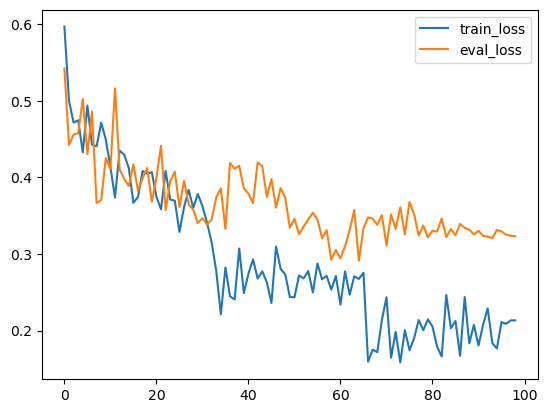

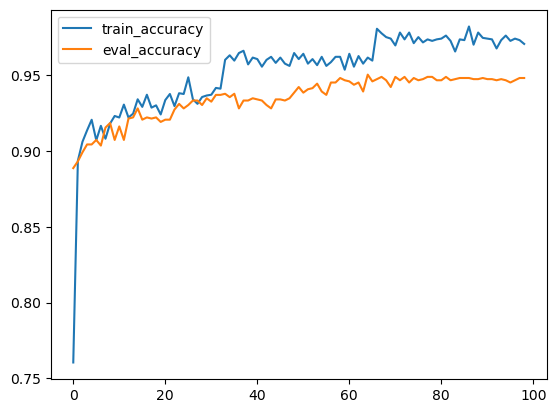

In [9]:
# Plot the results
import matplotlib.pyplot as plt

train_loss = []
train_accuracy = []
eval_loss = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log["loss"])
    if 'train_accuracy' in log:
        train_accuracy.append(log["train_accuracy"])
    elif 'eval_loss' in log:
        eval_loss.append(log["eval_loss"])
        eval_accuracy.append(log["eval_accuracy"])

plt.plot(train_loss, label="train_loss")
plt.plot(eval_loss, label="eval_loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(eval_accuracy, label="eval_accuracy")
plt.legend()
plt.show()

In [10]:
# Load the best model and test 

# Find the best model checkpoint
max_accuracy = 0
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        if log['eval_accuracy'] > max_accuracy:
            max_accuracy = log['eval_accuracy']
            best_checkpoint = log['step']

print(best_checkpoint)

best_model = RobertaForSequenceClassification.from_pretrained(f"./base_results/checkpoint-{best_checkpoint}")

# Test the best model
trainer = Trainer(
    model=best_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.evaluate()


32500


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
100%|██████████| 218/218 [00:04<00:00, 46.77it/s]


{'eval_loss': 0.39210012555122375,
 'eval_accuracy': 0.9380733944954128,
 'eval_runtime': 4.6864,
 'eval_samples_per_second': 186.07,
 'eval_steps_per_second': 46.517}